# Alzheimer & MCI DeepLearning(CNN) Classifier
- ADNI MRI 이미지로 알츠하이머와 경도인지장애를 분류하는 딥러닝 프로젝트
- 데이터 출처
  - 메타데이터 : https://ida.loni.usc.edu/
  - MRI이미지 : https://www.kaggle.com/datasets/katalniraj/adni-extracted-axial
- 저작권에 의해 데이터는 깃허브에 업로드 하지 않았음

## Part2-2. Transfer Learning (ResNet50V2)
- 본 작업은 Google Colaboratory(Colab)에서 진행되었음.
  - Python version : 3.8
  - Tensorflow version : 2.9

### 1. Library & Data Import

- Library Import & Google Drive Mount

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns

import tensorflow as tf
from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import ResNet50V2

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- Directory 지정 & 폴더 확인

In [2]:
base_dir = "/content/drive/MyDrive/AI/Alzheimer/"
data_dir = base_dir + "Axial"

os.listdir(data_dir)

['CN', 'AD', 'MCI']

- Global 변수 지정
  - 이전 노트와 동일하게 설정
  - 클래스 순서, 이미지 크기(256), 배치사이즈(32), 채널(3), 에포크(10), 시드(42)

In [3]:
CLASSES = ['CN', 'MCI', 'AD']
IMG_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10
SEED = 42

- Data 불러오기

In [4]:
dataset = image_dataset_from_directory(
    data_dir,
    shuffle=True,
    class_names=CLASSES,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE,IMG_SIZE),
    seed=SEED
)

Found 5154 files belonging to 3 classes.


In [5]:
print(dataset.class_names)

['CN', 'MCI', 'AD']


### 2. Data Split & Prefetch

- Data Split
  - Train : Validation : Test = 0.8 : 0.1 : 0.1
  - Batch 단위로 묶인 데이터라 Batch단위로 Split

In [6]:
def dataset_split(ds, tr=0.8, val=0.1, test=0.1, shuffle=True, buf_size=10000, SEED=42):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(buf_size,seed=SEED)
  train_size = int(ds_size*tr)
  val_size = int(ds_size*test)
  
  train = ds.take(train_size)
  test0 = ds.skip(train_size)
  val = test0.take(val_size)
  test = test0.skip(val_size)

  return train,val,test

train_ds, val_ds, test_ds = dataset_split(dataset)
print("Split전 Batched data 개수")
print(f"Dataset : {len(dataset)}")
print("\nSplit후 Batched data 개수")
print(f"Train : {len(train_ds)}")
print(f"Validation : {len(val_ds)}")
print(f"Test : {len(test_ds)}")

Split전 Batched data 개수
Dataset : 162

Split후 Batched data 개수
Train : 129
Validation : 16
Test : 17


- Data Prefetch
  - 속도를 향상시키기 위한 목적

In [7]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### 3. Modeling (ResNet50V2)
- 데이터 특징 추출 부분을 ResNet50V2 사전학습모델에서 가져와서 진행
- 정규화
  - Resizing : (256,256)으로 크기 맞춤
  - Rescaling : 0~255의 데이터를 0~1로 정규화
- 데이터 증강 (Augmentation) - Train dataset에만 적용되는 layer
  - RandomFlip : 수직, 수평으로 데이터를 뒤집어 훈련데이터를 증강
  - RandomRotation : 0.1정도를 Random하게 기울여 훈련데이터를 증강
- 전이학습 모델
  - 데이터 특징 추출 layer (Feature Extractor)
    - ResNet50V2 Feature Extractor Layer
      - Residual Connection(=Skipped Connection)이 특징
      - 기울기 소실(Vanishing Gradient) 문제를 어느정도 해결할 수 있음
  - 데이터 분류 layer (Classifier)
    - Global Average Pooling으로 출력 데이터를 압축
    - 1개의 은닉층(노드수=1024, 활성화함수=relu)
      - 과적합이어도 좋으니 성능을 올려보기 위해 1024개의 노드를 지정...
    - 다중 분류 출력층(노드수=3, 활성화함수=softmax)
- 모델 컴파일(compile)
  - Optimizer : Adam
  - 손실함수 (Loss function) : Sparse Categorical Crossentropy
  - 평가지표 (Metrics) : Accuracy 

In [8]:
# ResNet50V2의 Feature Extractor 부분만을 import
resnet = ResNet50V2(weights='imagenet', include_top=False)
# 가중치가 학습되지 않도록 설정
for layer in resnet.layers:
  layer.trainable = False

- 정규화 및 증강 layer 정의

In [9]:
resize_rescale = Sequential([
    Resizing(IMG_SIZE, IMG_SIZE),
    Rescaling(1.0/255)
])
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical", seed=SEED),
    RandomRotation(0.1, seed=SEED)
])

- Model building

In [13]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)

model2 = Sequential([
    resize_rescale,
    data_augmentation,
    resnet,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(3, activation='softmax')
])
model2.build(input_shape)
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling2d_1   (32, 2048)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (32, 1024)                2098176   
                                                                 
 dense_3 (Dense)             (32, 3)                   3075      
                                                      

- Model Compile

In [14]:
model2.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['acc'])

### 4. Training Model (fit)

In [15]:
history2 = model2.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds
)

Epoch 1/10
129/129 [==============================] - 26s 167ms/step - loss: 1.1247 - acc: 0.5046 - val_loss: 1.0547 - val_acc: 0.5059
Epoch 2/10
129/129 [==============================] - 21s 159ms/step - loss: 0.8857 - acc: 0.5906 - val_loss: 0.8559 - val_acc: 0.6152
Epoch 3/10
129/129 [==============================] - 20s 157ms/step - loss: 0.8202 - acc: 0.6298 - val_loss: 0.8251 - val_acc: 0.5996
Epoch 4/10
129/129 [==============================] - 21s 159ms/step - loss: 0.7513 - acc: 0.6623 - val_loss: 1.0031 - val_acc: 0.5547
Epoch 5/10
129/129 [==============================] - 20s 158ms/step - loss: 0.7052 - acc: 0.6880 - val_loss: 0.7500 - val_acc: 0.6914
Epoch 6/10
129/129 [==============================] - 21s 164ms/step - loss: 0.6784 - acc: 0.7071 - val_loss: 0.6856 - val_acc: 0.6699
Epoch 7/10
129/129 [==============================] - 21s 163ms/step - loss: 0.6118 - acc: 0.7485 - val_loss: 0.6436 - val_acc: 0.7188
Epoch 8/10
129/129 [==============================] - 2

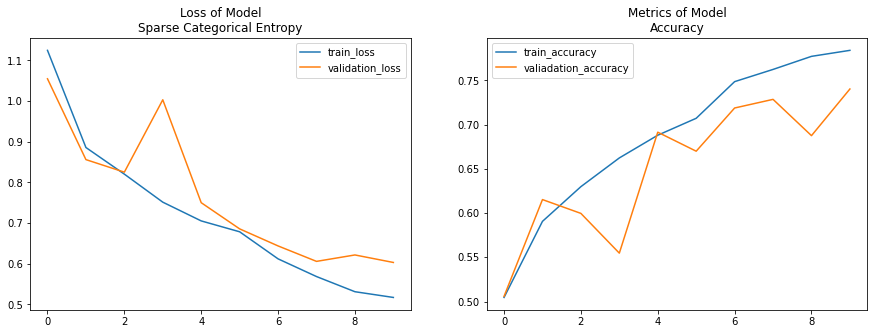

In [16]:
loss2 = history2.history['loss']
acc2 = history2.history['acc']
val_loss2 = history2.history['val_loss']
val_acc2 = history2.history['val_acc']

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(loss2, label="train_loss")
plt.plot(val_loss2, label="validation_loss")
plt.title("Loss of Model\nSparse Categorical Entropy")
plt.legend()

plt.subplot(122)
plt.plot(acc2, label="train_accuracy")
plt.plot(val_acc2, label="valiadation_accuracy")
plt.title("Metrics of Model\nAccuracy")
plt.legend()

plt.show()

- 오히려 더 불안정한 validation 곡선
- 성능이 오히려 감소함
- 전이학습에 의해 오히려 성능이 저하되는 Negative Transfer가 일어남
  - Negative transfer는 ppt에서 자세히 다루도록 하겠음

### 5. Evaluation (일반화 가능성 확인)

- 테스트 데이터셋 검증(Evaluation)

In [17]:
model2.evaluate(test_ds, verbose=1)

17/17 [==============================] - 18s 121ms/step - loss: 0.5526 - acc: 0.7647


[0.5526032447814941, 0.7647058963775635]

- 테스트 데이터셋 예측 클래스 확인
  - 성능이 개선되지 않았기 때문에 모델을 저장하거나 시각화하여 분석을 진행하지 않았음
  - Part3에서는 다음 노트에서 진행할 튜닝 모델을 저장해 이용하였음

In [18]:
predictions = model2.predict(test_ds)
predict_class = np.argmax(predictions, axis=1)
print(predict_class[:5])

17/17 [==============================] - 3s 115ms/step
[2 1 1 2 1]


## Part2-3 ~

- RAM 한도 초과로 인해 이후 과정들은 새로운 Colab file로 진행하였음.

- Part2-3. 모델 개선 2 : 하이퍼파라미터 튜닝 (Hyperparameter Tuning)
  - Keras-Tuner
  - Hyperband
- Part3. 최종모델 학습 & 튜닝 전후 모델 시각화 및 비교분석
  - Local에서 진행할 예정